In [1]:
from pygradu import shortest_path
from pygradu import gridify
from pygradu import portcalls

import shapely.geometry
import pandas as pd
import numpy as np
import importlib

RESULTS_DIR = 'data/results/'
DATASET_DIR = 'data/datasets/'
SHAPES_DIR = 'data/shapes/'

importlib.reload(gridify)

grid_2500m = gridify.area_to_grid(side_length=2500)
grid_5km = gridify.area_to_grid(side_length=5000)

validation_voyages_summer = pd.read_csv(DATASET_DIR + 'validation_set_summer.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])
validation_voyages_winter = pd.read_csv(DATASET_DIR + 'validation_set_winter.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])


Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 573
row_count 552
grid_size 316296
Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 286
row_count 276
grid_size 78936


In [2]:
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open(SHAPES_DIR + 'sea_areas.geojson') as f:
    sea_areas = json.load(f)

def get_sea_area_from_latlon(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['id']
    return -1

def get_sea_area_name_from_latlon(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'South'

def get_sea_area_name(sea_areas, _id):
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if int(feature['properties']['id']) == int(_id):
            return feature['properties']['name']
    return 'South'

In [3]:
importlib.reload(portcalls)

%time voyages_summer_lengths = portcalls.get_voyage_lengths(validation_voyages_summer)
%time voyages_winter_lengths = portcalls.get_voyage_lengths(validation_voyages_winter)
voyages_summer_lengths.head()

CPU times: user 20.4 s, sys: 43.9 ms, total: 20.5 s
Wall time: 20.5 s
CPU times: user 11 s, sys: 37.7 ms, total: 11.1 s
Wall time: 11.1 s


,voyage,voyage_length,start_end_length,difference,travel_time,avg_speed
0,14,393.001082,331.910305,18.405809,1366.066667,4.801574
1,67,509.627510,457.719607,11.340546,1442.483333,5.888805
2,88,612.745803,438.626106,39.696611,1723.316667,5.917536
3,93,1330.034728,1137.075860,16.969745,3856.666667,5.751125
4,94,842.476910,616.033928,36.758200,2349.216667,5.984929


In [6]:
ports = pd.read_csv(DATASET_DIR + 'ports.csv')
ports = ports[['port_id', 'lat', 'lon']]
print(len(ports))

ais_ports = pd.read_csv(DATASET_DIR + 'ports_calculated_from_ais.csv')
ais_ports = ais_ports[['id', 'lat', 'lon']]
ais_ports.columns=['port_id', 'lat', 'lon']

ports = ports.append(ais_ports)

157


In [7]:
importlib.reload(portcalls)
summer_results_5km_adj = pd.read_csv(RESULTS_DIR + 'summer_results_5km_adj_to_end.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])

voyages_summer = summer_results_5km_adj[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_summer['start_lat'] = voyages_summer.apply(lambda row: summer_results_5km_adj[summer_results_5km_adj.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_summer['start_lon'] = voyages_summer.apply(lambda row: summer_results_5km_adj[summer_results_5km_adj.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_summer['start_sea_area'] = voyages_summer.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_summer['start_port'] = voyages_summer.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [8]:
importlib.reload(portcalls)

winter_results_5km_adj_no_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_to_end_5km_adj_no_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])

voyages_winter = winter_results_5km_adj_no_dirway[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_winter['start_lat'] = voyages_winter.apply(lambda row: winter_results_5km_adj_no_dirway[winter_results_5km_adj_no_dirway.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_winter['start_lon'] = voyages_winter.apply(lambda row: winter_results_5km_adj_no_dirway[winter_results_5km_adj_no_dirway.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_winter['start_sea_area'] = voyages_winter.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_winter['start_port'] = voyages_summer.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [9]:
import matplotlib.pyplot as plt

def plot_intervals(results, col_x, col_y, interval):
    bins = []
    labels = []

    i = 0
    while i < results[col_x].max():
        bins.append(i)
        labels.append(int(i))
        i += interval
    del labels[0]

    results['interval'] = pd.cut(results[col_x], bins=bins, labels=labels)

    x = []
    y = []

    for group, voyage_results in results.groupby('interval'):
        if(len(voyage_results)) < 3:
            continue
        y.append(voyage_results[col_y].median())
        if np.isnan(group):
            group = 0
        x.append(group)
        
    return x, y

In [10]:
import pyproj

from shapely.geometry import Polygon
def calculate_route_accuracy(routes, test_voyages):
    routes_groupped = routes.groupby('voyage')
    areas = []
    for voyage, route in routes_groupped:
        real_route = test_voyages[(test_voyages.voyage == voyage)]

        x_y_curve1 = np.asarray(pyproj.transform(grid_5km.p_from, grid_5km.p_to, route.loc[:, ('lon')].values, route.loc[:, ('lat')].values))
        x_y_curve2 = np.asarray(pyproj.transform(grid_5km.p_from, grid_5km.p_to, real_route.loc[:, ('lon')].values, real_route.loc[:, ('lat')].values))
                
        polygon_points = [] #creates a empty list where we will append the points to create the polygon

        for i in range(len(x_y_curve1[0])):
            xy = [x_y_curve1[0][i], x_y_curve1[1][i]]
            polygon_points.append(xy) #append all xy points for curve 1

        for i in reversed(range(len(x_y_curve2[0]))):
            #print(i)
            xy = [x_y_curve2[0][i], x_y_curve2[1][i]]
            polygon_points.append(xy) #append all xy points for curve 2 in the reverse order (from last point to first point)

        xy = [x_y_curve1[0][0], x_y_curve1[1][0]]
        polygon_points.append(xy) #append the first point in curve 1 again, to it "closes" the polygon

        polygon = Polygon(polygon_points)
        areas.append([voyage, round(polygon.area/1000000, 2), real_route.iloc[0].end_port_sea_area])
    return pd.DataFrame(data=areas, columns=['voyage', 'diff_area_km2', 'end_port_sea_area'])

In [11]:
import pyproj

from shapely.geometry import Polygon
def calculate_route_accuracy_by_sea_area(routes, test_voyages, sea_area):
    routes_groupped = routes.groupby('voyage')
    areas = []
    for voyage, route in routes_groupped:
        real_route = test_voyages[(test_voyages.voyage == voyage) & (test_voyages.in_sea_area == sea_area)]
        
        route = route[route.in_sea_area == sea_area]
        
        if(len(route) < 3 or len(real_route) < 3):
            continue

        x_y_curve1 = np.asarray(pyproj.transform(grid_5km.p_from, grid_5km.p_to, route.loc[:, ('lon')].values, route.loc[:, ('lat')].values))
        x_y_curve2 = np.asarray(pyproj.transform(grid_5km.p_from, grid_5km.p_to, real_route.loc[:, ('lon')].values, real_route.loc[:, ('lat')].values))
                
        polygon_points = [] #creates a empty list where we will append the points to create the polygon

        for i in range(len(x_y_curve1[0])):
            xy = [x_y_curve1[0][i], x_y_curve1[1][i]]
            polygon_points.append(xy) #append all xy points for curve 1

        for i in reversed(range(len(x_y_curve2[0]))):
            #print(i)
            xy = [x_y_curve2[0][i], x_y_curve2[1][i]]
            polygon_points.append(xy) #append all xy points for curve 2 in the reverse order (from last point to first point)

        xy = [x_y_curve1[0][0], x_y_curve1[1][0]]
        polygon_points.append(xy) #append the first point in curve 1 again, to it "closes" the polygon

        polygon = Polygon(polygon_points)
        areas.append([voyage, round(polygon.area/1000000, 2), real_route.iloc[0].end_port_sea_area])
    return pd.DataFrame(data=areas, columns=['voyage', 'diff_area_km2', 'end_port_sea_area'])

In [62]:
sea_area_ids = []
for feature in sea_areas['features']:
    sea_area_ids.append(feature['properties']['id'])

def calculate_route_results(route_results, voyages, voyage_lengts):
    
    sea_area_accuracies = []
    for sea_area in sea_area_ids:
        if(sea_area == -1):
            continue
        voyage_in_sea_areas = route_results[route_results.in_sea_area == sea_area][['voyage', 'in_sea_area']].drop_duplicates()
        sea_area_results = route_results[route_results.voyage.isin(voyage_in_sea_areas.voyage.values)]
        accuracy = calculate_route_accuracy_by_sea_area(sea_area_results, voyages, sea_area).drop_duplicates()
        voyage_lengths = voyage_lengts[voyage_lengts.voyage.isin(sea_area_results.voyage.drop_duplicates().values)].voyage_length
        sea_area_accuracies.append([sea_area, accuracy.median().diff_area_km2, accuracy.mean().diff_area_km2, accuracy.std().diff_area_km2, len(accuracy)])

    sea_area_accuracies = pd.DataFrame(data=sea_area_accuracies, columns=['sea_area', 'median_diff_area_km2', 'mean_diff_area_km2', 'std_diff_area_km2', 'count'])
    sea_area_accuracies['sea_area_name'] = sea_area_accuracies.apply(lambda row: get_sea_area_name(sea_areas, row.sea_area), axis=1)
    sea_area_accuracies = sea_area_accuracies[['sea_area_name', 'median_diff_area_km2', 'mean_diff_area_km2', 'std_diff_area_km2', 'count']].sort_values(by='median_diff_area_km2')
    return sea_area_accuracies

## Summer results by sea areas

In [51]:
summer_routes_ship_model_5km = pd.read_csv(RESULTS_DIR + 'summer_routes_ship_model_5km.csv', index_col=0, parse_dates = ['start_time'])
summer_routes_ship_model_5km.head()

,lat,lon,node,speed,mmsi,voyage,start_time,number,timestamp,vessel_type,end_port_sea_area,start_port_sea_area
0,53.974982,11.340805,3354.0,4.630000,209014000,14,2019-06-07 11:27:49,0,-1,GC,-1,-1
1,54.056273,11.486634,3632.0,4.669002,209014000,14,2019-06-07 11:27:49,1,-1,GC,-1,-1
2,54.206419,11.585086,4462.0,4.647240,209014000,14,2019-06-07 11:27:49,2,-1,GC,-1,-1
3,54.279040,11.791794,4741.0,5.518313,209014000,14,2019-06-07 11:27:49,3,-1,GC,-1,-1
4,54.351346,11.999288,5020.0,4.826312,209014000,14,2019-06-07 11:27:49,4,-1,GC,-1,-1


#### Helper column for examining results by sea areas

In [53]:
summer_routes_ship_model_5km['in_sea_area'] = summer_routes_ship_model_5km.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.lat, row.lon), axis=1)
validation_voyages_summer['in_sea_area'] = validation_voyages_summer.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.lat, row.lon), axis=1)

#### Difference area by sea areas

In [54]:
calculate_route_results(summer_routes_ship_model_5km, validation_voyages_summer, voyages_summer_lengths).round(1)

,sea_area_name,median_diff_area_km2,mean_diff_area_km2,std_diff_area_km2,count
9,Saimaa,13.1,31.1,43.2,21
2,Gdansk Basin,81.6,104.3,72.7,61
6,Åland Sea,179.7,1127.8,2796.3,121
0,Bothnian Bay,212.8,413.1,460.2,36
1,Gulf of Riga,227.0,1318.3,2199.2,33
3,Gulf of Finland,292.4,620.3,787.2,84
4,Arkona Basin & Bomholm Basin,388.8,3375.7,7865.4,113
5,Gotland Basin,606.1,2129.3,3915.8,182
8,Bothnian Sea & The Quark,718.0,1638.4,2658.3,79
7,Northern Baltic Proper,981.0,1584.3,1774.4,126


#### Difference area by sea areas when voyages with big errors are removed

In [55]:
big_error_voyages = calculate_route_accuracy(summer_routes_ship_model_5km, validation_voyages_summer)
big_error_voyages = big_error_voyages[big_error_voyages.diff_area_km2 > 5000].voyage.values
summer_routes_wo_big_errors = summer_routes_ship_model_5km[~summer_routes_ship_model_5km.voyage.isin(big_error_voyages)]

calculate_route_results(summer_routes_wo_big_errors, validation_voyages_summer, voyages_summer_lengths).round(1)

,sea_area_name,median_diff_area_km2,mean_diff_area_km2,std_diff_area_km2,count
8,Saimaa,13.1,31.1,43.2,21
2,Gdansk Basin,81.6,101.4,66.6,43
6,Åland Sea,176.3,424.4,563.8,91
1,Gulf of Riga,185.8,403.6,823.6,23
4,Arkona Basin & Bomholm Basin,189.5,425.9,577.4,77
0,Bothnian Bay,191.6,395.7,474.6,28
3,Gulf of Finland,240.9,418.4,538.5,64
5,Gotland Basin,355.7,837.9,1093.6,132
7,Bothnian Sea & The Quark,538.6,842.9,1026.6,58
9,Northern Baltic Proper,746.4,899.3,726.2,91


## Winter results by sea areas

In [63]:
winter_routes_ship_5km_no_dirways = pd.read_csv(RESULTS_DIR + 'winter_routes_ship_5km_no_dirways.csv', index_col=0, parse_dates = ['start_time'])
winter_routes_ship_5km_dirways = pd.read_csv(RESULTS_DIR + 'winter_routes_ship_5km_dirways.csv', index_col=0, parse_dates = ['start_time'])

winter_routes_ship_5km_no_dirways['in_sea_area'] = winter_routes_ship_5km_no_dirways.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.lat, row.lon), axis=1)
winter_routes_ship_5km_dirways['in_sea_area'] = winter_routes_ship_5km_dirways.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.lat, row.lon), axis=1)

In [28]:
winter_routes_ship_5km_no_dirways.head()

,lat,lon,node,speed,mmsi,voyage,start_time,number,timestamp,in_sea_area
0,61.622263,17.241178,45959.0,5.610000,209185000,5,2019-03-20 14:44:01,0,-1,3
1,61.593594,17.484973,45685.0,6.026451,209185000,5,2019-03-20 14:44:01,1,-1,3
2,61.657533,17.752064,45964.0,6.050522,209185000,5,2019-03-20 14:44:01,2,-1,3
3,61.803841,17.899865,46794.0,6.190000,209185000,5,2019-03-20 14:44:01,3,-1,3
4,61.950016,18.049041,47624.0,4.974634,209185000,5,2019-03-20 14:44:01,4,-1,3


In [22]:
validation_voyages_winter['in_sea_area'] = validation_voyages_winter.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.lat, row.lon), axis=1)

In [64]:
calculate_route_results(winter_routes_ship_5km_no_dirways, validation_voyages_winter, voyages_winter_lengths)

,sea_area_name,median_diff_area_km2,mean_diff_area_km2,std_diff_area_km2,count
5,Gulf of Riga,80.880,74.950000,33.550376,3
2,Åland Sea,244.350,564.794074,1775.212559,54
3,Gulf of Finland,467.225,479.272500,273.320257,4
1,Bothnian Sea & The Quark,511.030,1437.709571,3148.307009,70
6,Gotland Basin,532.150,842.951064,1384.280609,47
8,Arkona Basin & Bomholm Basin,622.030,1384.885714,4474.116489,35
4,Northern Baltic Proper,900.380,1327.334528,1405.962485,53
0,Bothnian Bay,1717.000,2855.669125,2860.727953,80
7,Gdansk Basin,NaN,NaN,NaN,0
9,Saimaa,NaN,NaN,NaN,0


In [65]:
calculate_route_results(winter_routes_ship_5km_dirways, validation_voyages_winter, voyages_winter_lengths)

,sea_area_name,median_diff_area_km2,mean_diff_area_km2,std_diff_area_km2,count
5,Gulf of Riga,80.880,74.950000,33.550376,3
2,Åland Sea,239.585,557.321111,1771.807720,54
3,Gulf of Finland,336.480,359.315000,185.435118,4
0,Bothnian Bay,368.825,1303.082000,2186.010309,80
1,Bothnian Sea & The Quark,415.605,1329.313571,3035.098764,70
6,Gotland Basin,486.900,764.568723,1379.321483,47
8,Arkona Basin & Bomholm Basin,622.030,1384.810286,4473.623579,35
4,Northern Baltic Proper,900.380,1333.848679,1404.095596,53
7,Gdansk Basin,NaN,NaN,NaN,0
9,Saimaa,NaN,NaN,NaN,0


#### Examining route prediction results in summer with different maneovaribility models

In [67]:
summer_routes_adjacent_5km = pd.read_csv(RESULTS_DIR + 'summer_routes_adjacent_5km.csv', index_col=0, parse_dates = ['start_time'])
summer_routes_adjacent_2500m = pd.read_csv(RESULTS_DIR + 'summer_routes_adjacent_2500m.csv', index_col=0, parse_dates = ['start_time'])

In [75]:
summer_ship_5km_routeacc = calculate_route_accuracy(summer_routes_ship_model_5km, validation_voyages_summer)
summer_adj_5km_routeacc = calculate_route_accuracy(summer_routes_adjacent_5km, validation_voyages_summer)
summer_adj_2500m_routeacc = calculate_route_accuracy(summer_routes_adjacent_2500m, validation_voyages_summer)


def get_voyage_length(voyage, voyage_lengths):
    return voyage_lengths[voyage_lengths.voyage == voyage].voyage_length.iloc[0]

summer_ship_5km_routeacc['voyage_length'] = summer_ship_5km_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_summer_lengths), axis=1)
summer_adj_5km_routeacc['voyage_length'] = summer_adj_5km_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_summer_lengths), axis=1)
summer_adj_2500m_routeacc['voyage_length'] = summer_adj_2500m_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_summer_lengths), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


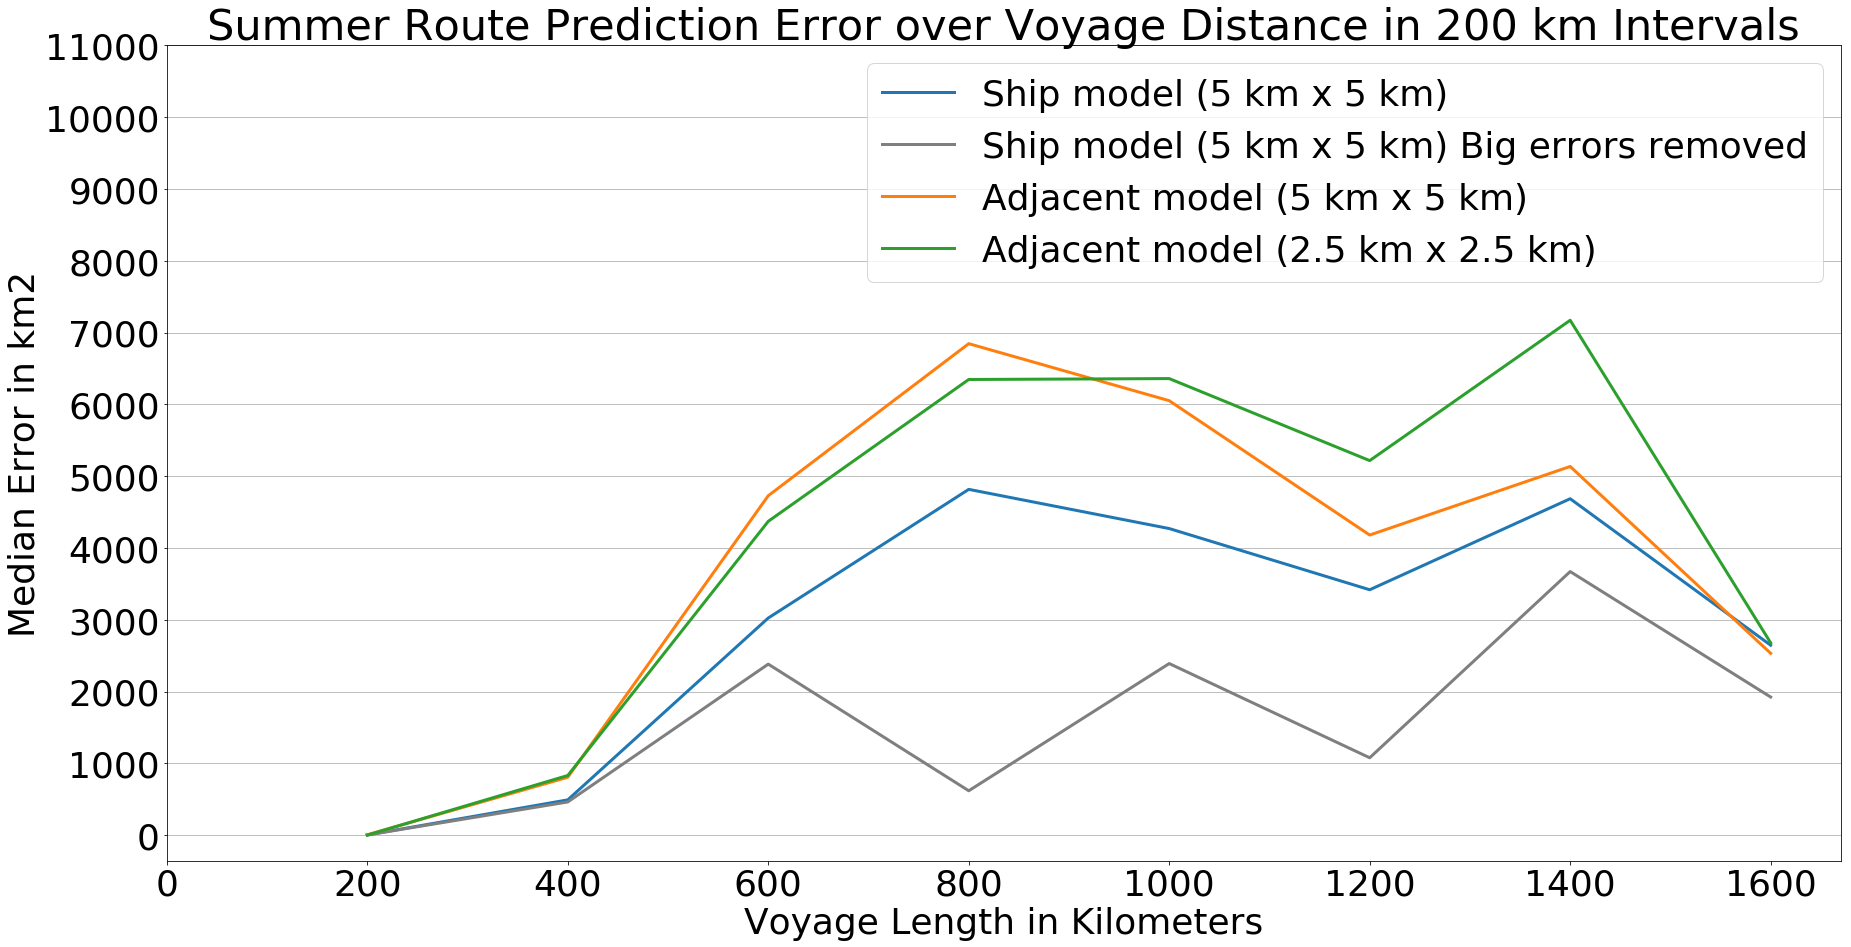

In [91]:
from scipy.interpolate import make_interp_spline, BSpline



fig = plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 36})

x, y = plot_intervals(summer_ship_5km_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:blue', label='Ship model (5 km x 5 km)')

x, y = plot_intervals(summer_ship_5km_routeacc[~summer_ship_5km_routeacc.voyage.isin(big_error_voyages)],'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:grey', label='Ship model (5 km x 5 km) Big errors removed')

x, y = plot_intervals(summer_adj_5km_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:orange', label='Adjacent model (5 km x 5 km)')

x, y = plot_intervals(summer_adj_2500m_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:green', label='Adjacent model (2.5 km x 2.5 km)')


plt.xticks(np.arange(0, 1800, 200)) 
plt.yticks(np.arange(0, 12000, 1000))
plt.grid(axis='y', alpha=1)

plt.title(f"Summer Route Prediction Error over Voyage Distance in 200 km Intervals")
plt.ylabel("Median Error in km2")
plt.xlabel("Voyage Length in Kilometers")
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.show()


#### Examining winter prediction results in summer with different maneovaribility models

In [77]:
winter_routes_adjacent_5km_no_dirways = pd.read_csv(RESULTS_DIR + 'winter_routes_adjacent_5km_no_dirways.csv', index_col=0, parse_dates = ['start_time'])
winter_routes_adjacent_5km_dirways = pd.read_csv(RESULTS_DIR + 'winter_routes_adjacent_5km_dirways.csv', index_col=0, parse_dates = ['start_time'])


winter_ship_5km_no_dirway_routeacc = calculate_route_accuracy(winter_routes_ship_5km_no_dirways, validation_voyages_winter)
winter_ship_5km_dirway_routeacc = calculate_route_accuracy(winter_routes_ship_5km_dirways, validation_voyages_winter)
winter_adj_5km_dirway_routeacc = calculate_route_accuracy(winter_routes_adjacent_5km_dirways, validation_voyages_winter)
winter_adj_5km_no_dirway_routeacc = calculate_route_accuracy(winter_routes_adjacent_5km_no_dirways, validation_voyages_winter)

winter_ship_5km_no_dirway_routeacc['voyage_length'] = winter_ship_5km_no_dirway_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_winter_lengths), axis=1)
winter_ship_5km_dirway_routeacc['voyage_length'] = winter_ship_5km_dirway_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_winter_lengths), axis=1)
winter_adj_5km_dirway_routeacc['voyage_length'] = winter_adj_5km_dirway_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_winter_lengths), axis=1)
winter_adj_5km_no_dirway_routeacc['voyage_length'] = winter_adj_5km_no_dirway_routeacc.apply(lambda row: get_voyage_length(row.voyage, voyages_winter_lengths), axis=1)

Ship model, dirway OFF (5 km x 5 km)
Ship model, dirway ON (5 km x 5 km)
Adjacent model, dirway ON (5 km x 5 km)
Adjacent model, dirway ON (5 km x 5 km)


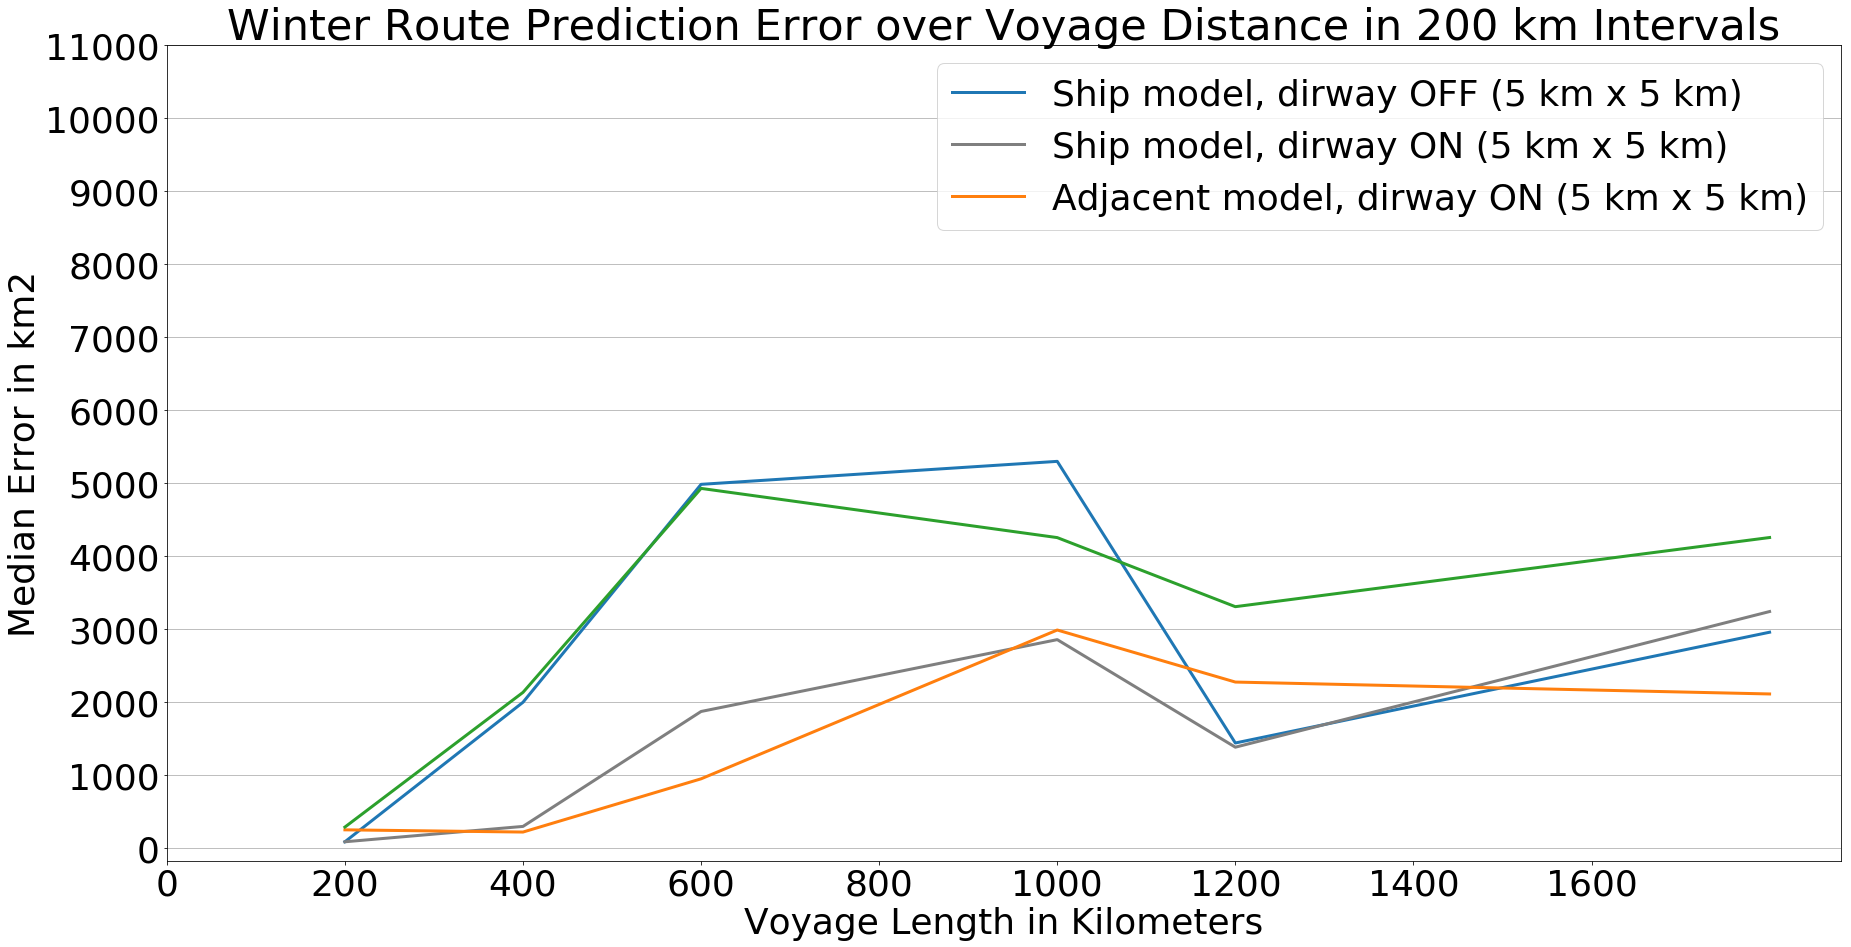

In [90]:
from scipy.interpolate import make_interp_spline, BSpline



fig = plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 36})

x, y = plot_intervals(winter_ship_5km_no_dirway_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:blue', label='Ship model, dirway OFF (5 km x 5 km)')

x, y = plot_intervals(winter_ship_5km_dirway_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:grey', label='Ship model, dirway ON (5 km x 5 km)')

x, y = plot_intervals(winter_adj_5km_dirway_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:orange', label='Adjacent model, dirway ON (5 km x 5 km)')

x, y = plot_intervals(winter_adj_5km_no_dirway_routeacc,'voyage_length', 'diff_area_km2', 200)
plt.plot(x, y, alpha=1, linewidth=3, c='tab:green', label='Adjacent model, dirway ON (5 km x 5 km)')


plt.xticks(np.arange(0, 1800, 200))
plt.yticks(np.arange(0, 12000, 1000))
plt.grid(axis='y', alpha=1)

plt.title(f"Winter Route Prediction Error over Voyage Distance in 200 km Intervals")
plt.ylabel("Median Error in km2")
plt.xlabel("Voyage Length in Kilometers")
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    print(label)
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
        
plt.legend(newHandles, newLabels)
plt.show()


In [89]:
# Results by vessel type

type_results_df = []
for v_type, type_results in summer_routes_ship_model_5km.groupby('vessel_type'):
    accuracy = calculate_route_accuracy(type_results, validation_voyages_summer)
    accuracy['voyage_length'] = accuracy.apply(lambda row: get_voyage_length(row.voyage, voyages_summer_lengths), axis=1)
    big_errors = len(accuracy[accuracy.diff_area_km2 > 5000])
    count = len(accuracy)
    big_error_percentage = big_errors/count * 100
    type_results_df.append([v_type, accuracy.diff_area_km2.mean(), accuracy.diff_area_km2.std(), accuracy.voyage_length.mean(), accuracy.voyage_length.std(), len(accuracy[accuracy.diff_area_km2 > 5000]),  round(big_error_percentage,1), len(accuracy)])
type_results = pd.DataFrame(data=type_results_df, columns=['Type', 'Mean', 'STD', 'Mean Voayge Length', 'STD Voayge Length','Big Errors (> 5000 km2) ', 'Percentage of Big Errors', 'Total count'])
type_results = type_results.sort_values('Mean')
type_results = type_results.round(1)
type_results

,Type,Mean,STD,Mean Voayge Length,STD Voayge Length,Big Errors (> 5000 km2),Percentage of Big Errors,Total count
2,PAS,1992.2,4834.2,339.1,110.9,8,8.3,96
0,CONT,2902.8,2461.2,471.2,126.0,3,27.3,11
1,GC,4175.7,7562.3,523.8,365.5,35,22.0,159
4,T,6498.8,8199.0,683.9,399.8,16,37.2,43
3,RORO,9808.3,8637.2,946.0,280.5,10,47.6,21
